# SC2001 Project 3: Dynamic Programming
## Unbounded Knapsack Problem

**Problem Statement:**  
We have a knapsack of capacity weight C (a positive integer) and n types of objects.  
Each object of the ith type has weight wᵢ and profit pᵢ (all wᵢ and all pᵢ are positive integers, i = 0, 1, …, n-1).  
There are unlimited supplies of each type of objects.  
Find the largest total profit of any set of the objects that fits in the knapsack.

Let P(C) be the maximum profit that can be made by packing objects into the knapsack of capacity C.

## Part 1: Recursive Definition of P(C)

The recursive definition of P(C) is:

$$
P(C) = \begin{cases}
0 & \text{if } C = 0 \\
\max_{i: w_i \leq C} \{p_i + P(C - w_i)\} & \text{if } C > 0
\end{cases}
$$

**Explanation:**
- **Base case:** If the capacity is 0, the maximum profit is 0 (no items can be added).
- **Recursive case:** For capacity C > 0, we try adding each object type i whose weight wᵢ ≤ C. For each such object, we get profit pᵢ and solve the subproblem for remaining capacity C - wᵢ. We take the maximum profit among all choices.

Since we have unlimited supplies, after taking an object of type i, it remains available for the subproblem P(C - wᵢ).

In [11]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyBboxPatch
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

## Part 2: Subproblem Graph for P(14)

Given:
- Capacity C = 14
- n = 3 objects
- Weights: w = [4, 6, 8]
- Profits: p = [7, 6, 9]

The subproblem graph shows all subproblems P(i) that need to be solved and their dependencies.

SUBPROBLEM GRAPH FOR P(14)


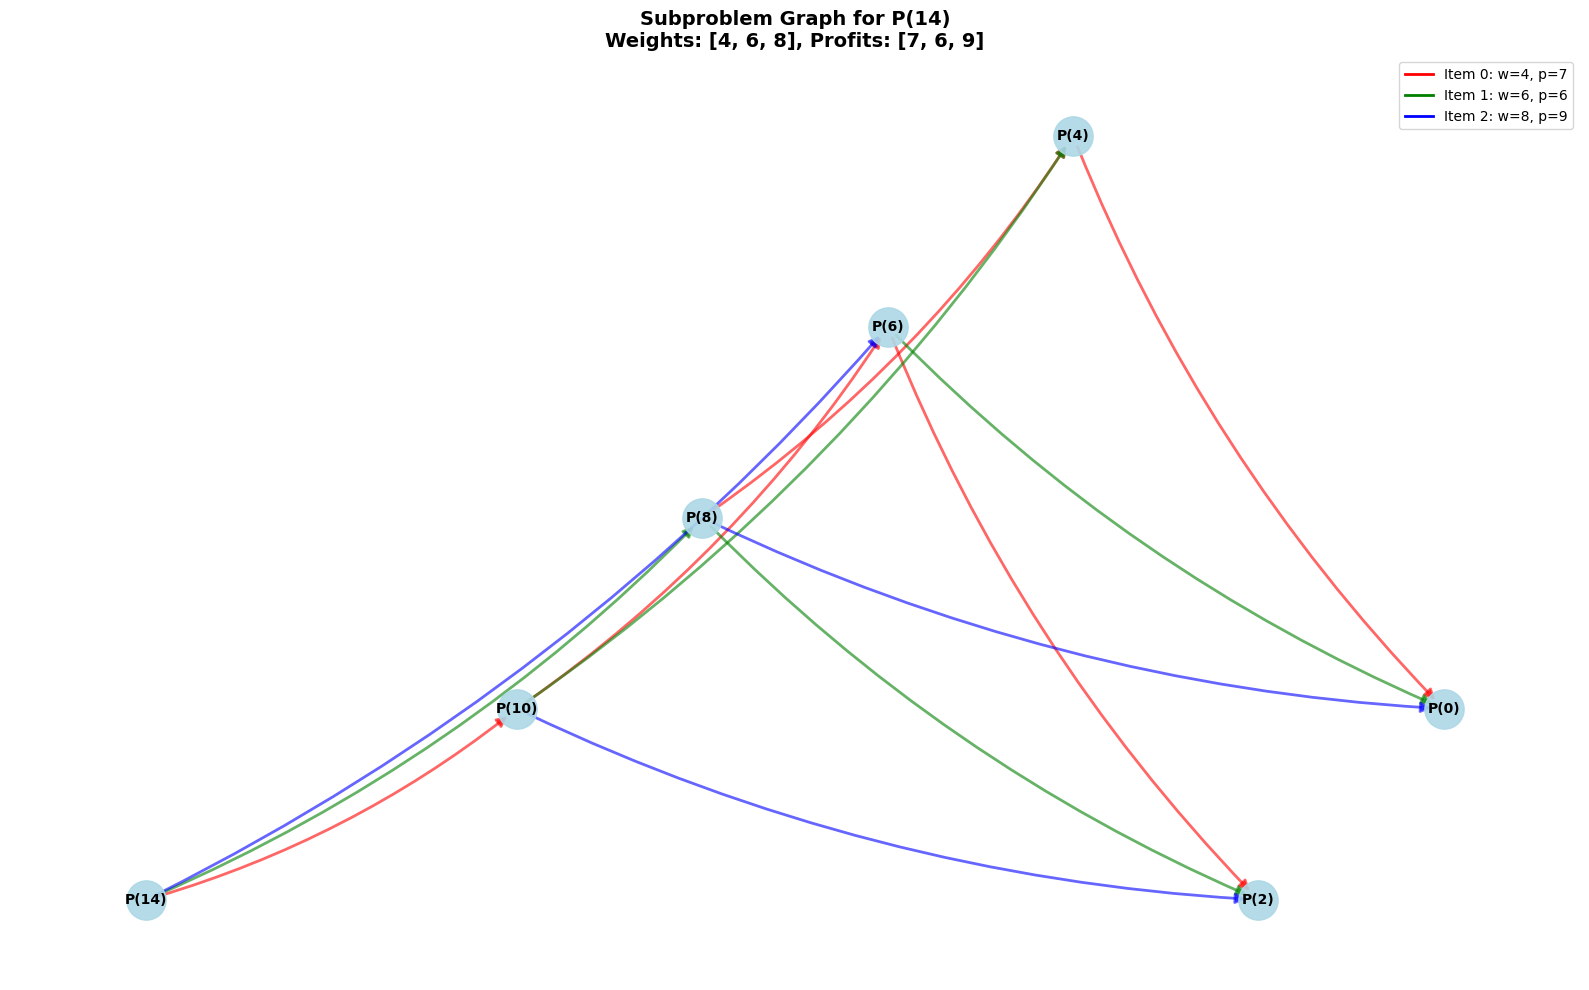


Graph Statistics:
Total subproblems (nodes): 7
Total dependencies (edges): 12
Subproblems to solve: [14, 10, 8, 6, 4, 2, 0]


In [12]:
def generate_subproblem_graph(C, weights, profits):
    """
    Generate the subproblem graph for the unbounded knapsack problem.
    Returns a directed graph where nodes represent subproblems P(c) and
    edges represent dependencies.
    """
    G = nx.DiGraph()
    
    # Use BFS to explore all reachable subproblems
    visited = set()
    queue = [C]
    visited.add(C)
    
    while queue:
        current_capacity = queue.pop(0)
        G.add_node(current_capacity)
        
        # Try each object type
        for i, w in enumerate(weights):
            if w <= current_capacity:
                next_capacity = current_capacity - w
                # Add edge with label showing which item was used
                G.add_edge(current_capacity, next_capacity, 
                          item=i, weight=w, profit=profits[i])
                
                if next_capacity not in visited:
                    visited.add(next_capacity)
                    queue.append(next_capacity)
    
    return G

def draw_subproblem_graph(C, weights, profits):
    """
    Draw the subproblem graph for visualization.
    """
    G = generate_subproblem_graph(C, weights, profits)
    
    plt.figure(figsize=(16, 10))
    
    # Create a layered layout based on capacity
    pos = {}
    nodes_sorted = sorted(G.nodes(), reverse=True)
    
    # Calculate positions
    max_capacity = max(G.nodes())
    for i, node in enumerate(nodes_sorted):
        # x position based on capacity (right to left, high to low)
        x = (max_capacity - node) * 1.5
        # y position with some spreading for readability
        y = (i % 5) * 2 - 4
        pos[node] = (x, y)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                          node_size=800, alpha=0.9)
    
    # Draw labels
    labels = {node: f'P({node})' for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')
    
    # Draw edges with different colors for different items
    colors = ['red', 'green', 'blue']
    for i in range(len(weights)):
        edges_for_item = [(u, v) for u, v, d in G.edges(data=True) if d['item'] == i]
        nx.draw_networkx_edges(G, pos, edges_for_item, 
                              edge_color=colors[i], 
                              arrows=True, arrowsize=15, 
                              width=2, alpha=0.6,
                              connectionstyle='arc3,rad=0.1')
    
    # Create legend
    legend_elements = []
    for i in range(len(weights)):
        legend_elements.append(plt.Line2D([0], [0], color=colors[i], linewidth=2, 
                                         label=f'Item {i}: w={weights[i]}, p={profits[i]}'))
    plt.legend(handles=legend_elements, loc='upper right', fontsize=10)
    
    plt.title(f'Subproblem Graph for P({C})\nWeights: {weights}, Profits: {profits}', 
             fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print graph statistics
    print(f"\nGraph Statistics:")
    print(f"Total subproblems (nodes): {G.number_of_nodes()}")
    print(f"Total dependencies (edges): {G.number_of_edges()}")
    print(f"Subproblems to solve: {sorted(G.nodes(), reverse=True)}")

# Generate graph for test case in part 2
weights_test1 = [4, 6, 8]
profits_test1 = [7, 6, 9]
C_test = 14

print("=" * 60)
print("SUBPROBLEM GRAPH FOR P(14)")
print("=" * 60)
draw_subproblem_graph(C_test, weights_test1, profits_test1)

## Part 3: Dynamic Programming Algorithm (Bottom-Up)

**Algorithm Description:**

The bottom-up dynamic programming approach solves the problem iteratively:

1. Create a DP table `dp[0..C]` where `dp[c]` stores the maximum profit for capacity c
2. Initialize `dp[0] = 0` (base case)
3. For each capacity c from 1 to C:
   - For each item i where wᵢ ≤ c:
     - Consider taking item i: profit = pᵢ + dp[c - wᵢ]
     - Update dp[c] = max(dp[c], profit)
4. Return dp[C]

**Time Complexity:** O(n × C)  
**Space Complexity:** O(C)

In [13]:
def unbounded_knapsack(C, weights, profits):
    """
    Solve the unbounded knapsack problem using dynamic programming (bottom-up).
    
    Parameters:
    - C: knapsack capacity
    - weights: list of item weights
    - profits: list of item profits
    
    Returns:
    - max_profit: maximum profit achievable
    - dp: DP table showing profit for each capacity
    - items_used: list of items used to achieve maximum profit
    """
    n = len(weights)
    
    # DP table: dp[c] = maximum profit for capacity c
    dp = [0] * (C + 1)
    
    # Track which item was used to achieve dp[c]
    item_used = [-1] * (C + 1)
    
    # Fill the DP table bottom-up
    for c in range(1, C + 1):
        for i in range(n):
            if weights[i] <= c:
                profit = profits[i] + dp[c - weights[i]]
                if profit > dp[c]:
                    dp[c] = profit
                    item_used[c] = i
    
    # Backtrack to find which items were used
    items_used = []
    capacity = C
    while capacity > 0 and item_used[capacity] != -1:
        item = item_used[capacity]
        items_used.append(item)
        capacity -= weights[item]
    
    return dp[C], dp, items_used

def print_solution(C, weights, profits, max_profit, dp, items_used):
    """
    Print the solution in a formatted way.
    """
    print(f"\nKnapsack Capacity: {C}")
    print(f"Weights: {weights}")
    print(f"Profits: {profits}")
    print("\n" + "=" * 60)
    print("DP TABLE (Capacity -> Max Profit)")
    print("=" * 60)
    
    # Print DP table
    print("\nCapacity | ", end="")
    for i in range(len(dp)):
        print(f"{i:4d}", end=" ")
    print("\n" + "-" * (len(dp) * 5 + 10))
    print("Profit   | ", end="")
    for profit in dp:
        print(f"{profit:4d}", end=" ")
    print("\n")
    
    print("=" * 60)
    print("SOLUTION")
    print("=" * 60)
    print(f"\nMaximum Profit: {max_profit}")
    
    # Count items used
    item_count = Counter(items_used)
    
    print("\nItems Selected:")
    total_weight = 0
    total_profit = 0
    for item, count in sorted(item_count.items()):
        weight = weights[item]
        profit = profits[item]
        print(f"  Item {item}: {count} × (weight={weight}, profit={profit}) = "
              f"weight {count*weight}, profit {count*profit}")
        total_weight += count * weight
        total_profit += count * profit
    
    print(f"\nTotal Weight Used: {total_weight}/{C}")
    print(f"Total Profit: {total_profit}")
    print("=" * 60)

# Test the algorithm
print("\n" + "#" * 60)
print("DYNAMIC PROGRAMMING ALGORITHM IMPLEMENTATION")
print("#" * 60)


############################################################
DYNAMIC PROGRAMMING ALGORITHM IMPLEMENTATION
############################################################


## Part 4(a): Test Case 1

**Input:**
- Capacity C = 14
- Weights: [4, 6, 8]
- Profits: [7, 6, 9]

In [14]:
# Test Case 1: weights = [4, 6, 8], profits = [7, 6, 9]
C1 = 14
weights1 = [4, 6, 8]
profits1 = [7, 6, 9]

print("\n" + "=" * 60)
print("TEST CASE 1 (Part 4a)")
print("=" * 60)

max_profit1, dp1, items_used1 = unbounded_knapsack(C1, weights1, profits1)
print_solution(C1, weights1, profits1, max_profit1, dp1, items_used1)


TEST CASE 1 (Part 4a)

Knapsack Capacity: 14
Weights: [4, 6, 8]
Profits: [7, 6, 9]

DP TABLE (Capacity -> Max Profit)

Capacity |    0    1    2    3    4    5    6    7    8    9   10   11   12   13   14 
-------------------------------------------------------------------------------------
Profit   |    0    0    0    0    7    7    7    7   14   14   14   14   21   21   21 

SOLUTION

Maximum Profit: 21

Items Selected:
  Item 0: 3 × (weight=4, profit=7) = weight 12, profit 21

Total Weight Used: 12/14
Total Profit: 21


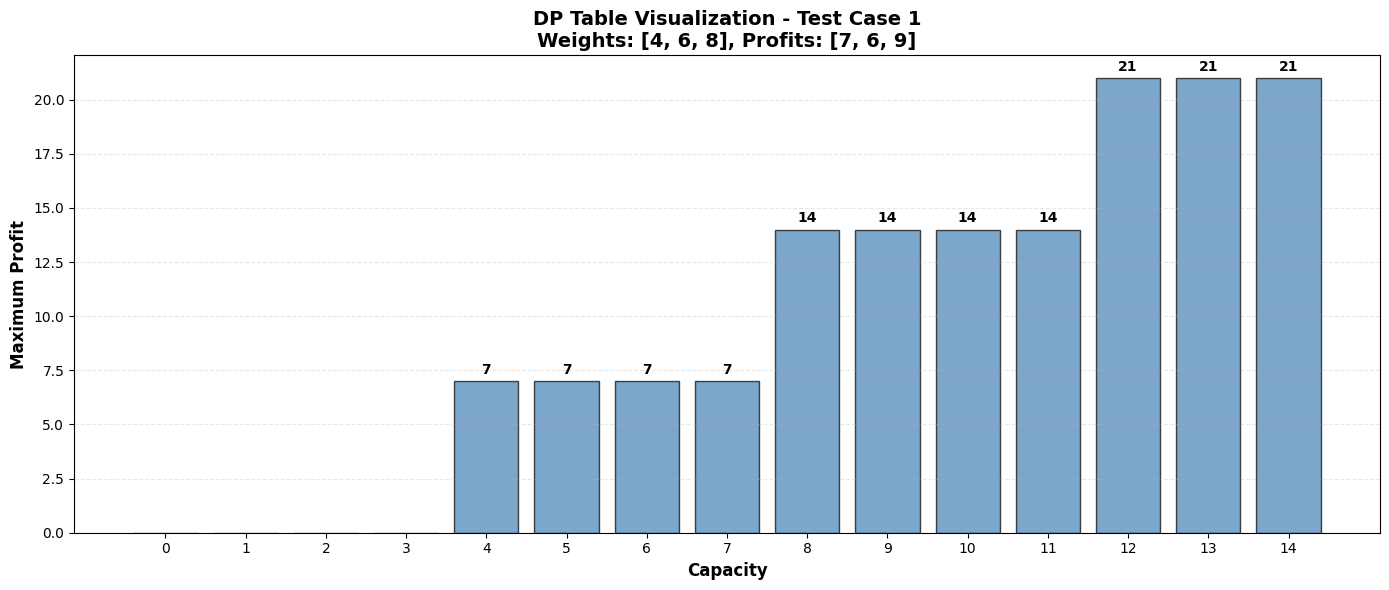

In [15]:
# Visualize the DP table for Test Case 1
def visualize_dp_table(dp, C, title):
    """
    Create a bar chart visualization of the DP table.
    """
    plt.figure(figsize=(14, 6))
    capacities = list(range(len(dp)))
    
    plt.bar(capacities, dp, color='steelblue', alpha=0.7, edgecolor='black')
    plt.xlabel('Capacity', fontsize=12, fontweight='bold')
    plt.ylabel('Maximum Profit', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(capacities)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, v in enumerate(dp):
        if v > 0:
            plt.text(i, v + 0.2, str(v), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

visualize_dp_table(dp1, C1, f'DP Table Visualization - Test Case 1\nWeights: {weights1}, Profits: {profits1}')

## Part 4(b): Test Case 2

**Input:**
- Capacity C = 14
- Weights: [5, 6, 8]
- Profits: [7, 6, 9]

In [16]:
# Test Case 2: weights = [5, 6, 8], profits = [7, 6, 9]
C2 = 14
weights2 = [5, 6, 8]
profits2 = [7, 6, 9]

print("\n" + "=" * 60)
print("TEST CASE 2 (Part 4b)")
print("=" * 60)

max_profit2, dp2, items_used2 = unbounded_knapsack(C2, weights2, profits2)
print_solution(C2, weights2, profits2, max_profit2, dp2, items_used2)


TEST CASE 2 (Part 4b)

Knapsack Capacity: 14
Weights: [5, 6, 8]
Profits: [7, 6, 9]

DP TABLE (Capacity -> Max Profit)

Capacity |    0    1    2    3    4    5    6    7    8    9   10   11   12   13   14 
-------------------------------------------------------------------------------------
Profit   |    0    0    0    0    0    7    7    7    9    9   14   14   14   16   16 

SOLUTION

Maximum Profit: 16

Items Selected:
  Item 0: 1 × (weight=5, profit=7) = weight 5, profit 7
  Item 2: 1 × (weight=8, profit=9) = weight 8, profit 9

Total Weight Used: 13/14
Total Profit: 16


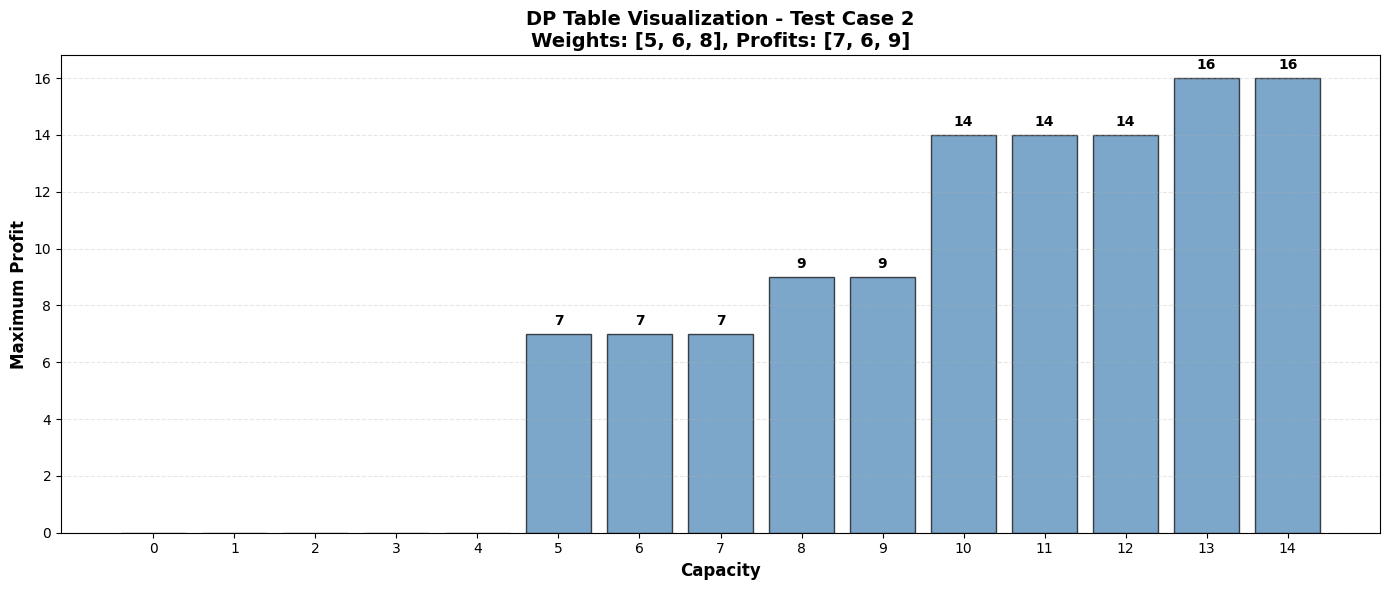

In [17]:
# Visualize the DP table for Test Case 2
visualize_dp_table(dp2, C2, f'DP Table Visualization - Test Case 2\nWeights: {weights2}, Profits: {profits2}')


SUBPROBLEM GRAPH FOR TEST CASE 2


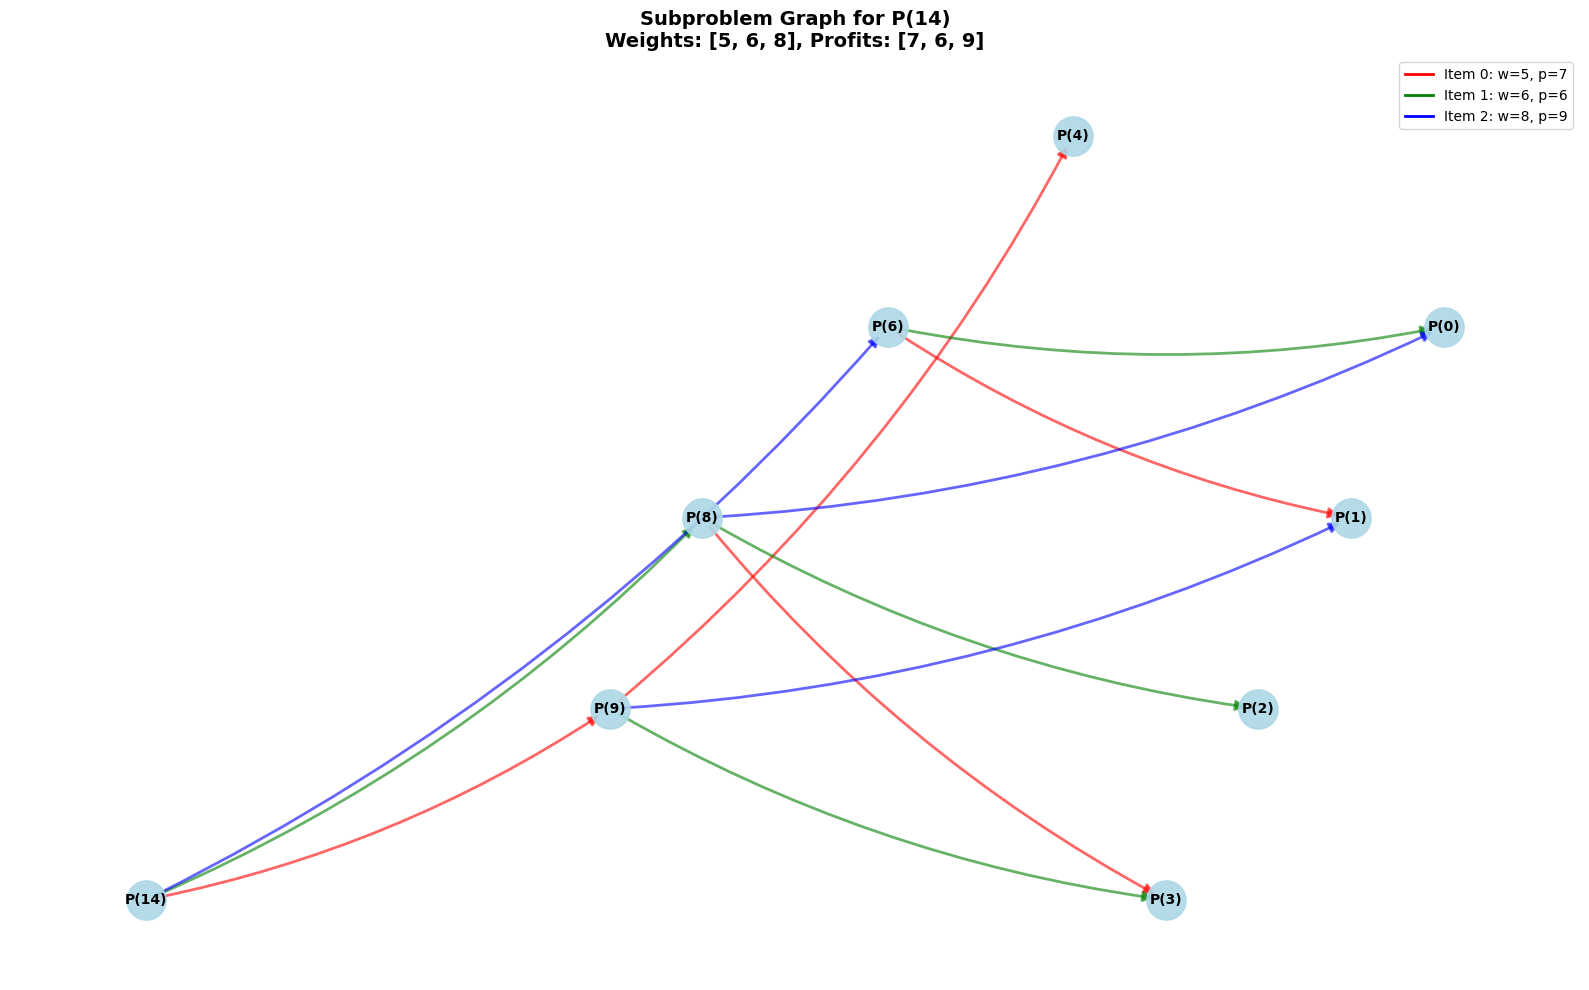


Graph Statistics:
Total subproblems (nodes): 9
Total dependencies (edges): 11
Subproblems to solve: [14, 9, 8, 6, 4, 3, 2, 1, 0]


In [18]:
# Draw subproblem graph for Test Case 2 as well
print("\n" + "=" * 60)
print("SUBPROBLEM GRAPH FOR TEST CASE 2")
print("=" * 60)
draw_subproblem_graph(C2, weights2, profits2)

## Comparison of Results


COMPARISON OF TEST CASES

Test Case 1: Weights=[4, 6, 8], Profits=[7, 6, 9]
  Maximum Profit for C=14: 21

Test Case 2: Weights=[5, 6, 8], Profits=[7, 6, 9]
  Maximum Profit for C=14: 16


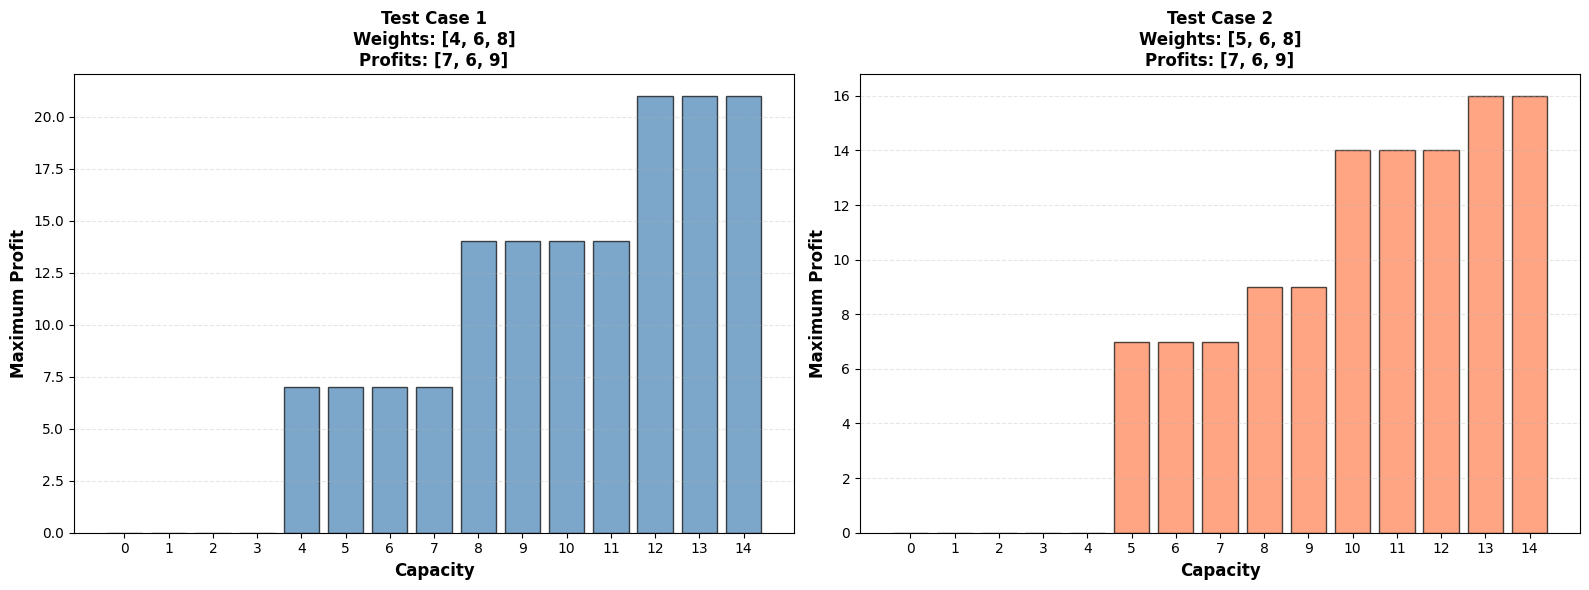

In [19]:
# Compare both test cases
print("\n" + "=" * 60)
print("COMPARISON OF TEST CASES")
print("=" * 60)

print(f"\nTest Case 1: Weights={weights1}, Profits={profits1}")
print(f"  Maximum Profit for C=14: {max_profit1}")

print(f"\nTest Case 2: Weights={weights2}, Profits={profits2}")
print(f"  Maximum Profit for C=14: {max_profit2}")

# Side-by-side comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Test Case 1
capacities = list(range(len(dp1)))
ax1.bar(capacities, dp1, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Capacity', fontsize=12, fontweight='bold')
ax1.set_ylabel('Maximum Profit', fontsize=12, fontweight='bold')
ax1.set_title(f'Test Case 1\nWeights: {weights1}\nProfits: {profits1}', 
             fontsize=12, fontweight='bold')
ax1.set_xticks(capacities)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Test Case 2
ax2.bar(capacities, dp2, color='coral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Capacity', fontsize=12, fontweight='bold')
ax2.set_ylabel('Maximum Profit', fontsize=12, fontweight='bold')
ax2.set_title(f'Test Case 2\nWeights: {weights2}\nProfits: {profits2}', 
             fontsize=12, fontweight='bold')
ax2.set_xticks(capacities)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

## Analysis and Observations

### Key Observations:

1. **Test Case 1 (weights=[4,6,8], profits=[7,6,9]):**
   - The algorithm finds the optimal combination of items
   - Item 0 (weight=4, profit=7) has the best profit-to-weight ratio (1.75)
   
2. **Test Case 2 (weights=[5,6,8], profits=[7,6,9]):**
   - Different weight for item 0 changes the optimal solution
   - The profit-to-weight ratios are different, affecting item selection

3. **Subproblem Graph:**
   - Shows all capacities that need to be computed
   - Edges represent taking a specific item
   - Some capacities may not be reachable depending on item weights

4. **Time Complexity:** O(n × C) where n is the number of item types and C is capacity

5. **Space Complexity:** O(C) for storing the DP table